# Heuristic reward with PPO and DQN agent

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 3
Chosen Meal: Pork tenderloin fried rice made with oyster sauce
Chosen Meal Category: Combo meal rice
Meal History: ['Braised pork belly and bean sprouts' 'Braised mini-potato'
 'Pork tenderloin fried rice made with oyster sauce']
Category History: ['Steamed' 'Braised' 'Combo meal rice']
Reward: 2.54116076872449
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 9.69
Saving new best model to ./tmp/gym/20230422-142339/best_model.zip
Num timesteps: 2000
Best mean reward: 9.69 - Last mean reward per episode: 9.70
Saving new best model to ./tmp/gym/20230422-142339/best_model.zip
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 9.7      |
| time/              |          |
|    fps             | 997      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
-----------------------------

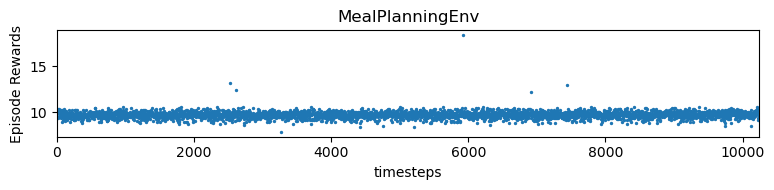

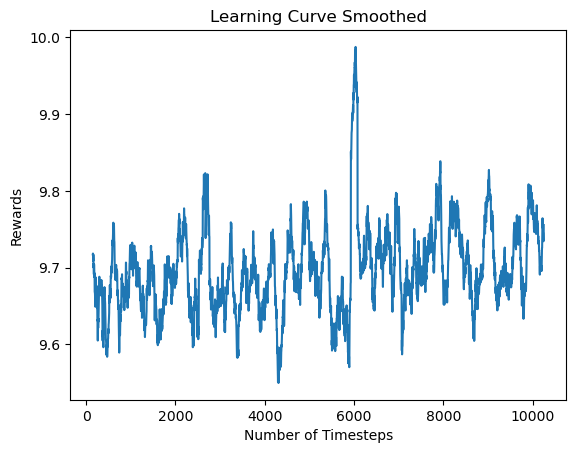

In [2]:
from stable_baselines3 import PPO, DQN
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter


log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=True)


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()


all_ingredients = load_ingredient(sample_language='eng')
meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
example_mealplans = load_diet(
    menus=meal_dict, 
    num_loads=100, 
    sample_language='eng', 
    sample_name='ML'
)

# downsample meals to size num_possible_meals
num_possible_meals = len(meal_dict.keys())
old_meal_dict = meal_dict
keys_to_keep = np.random.choice(list(meal_dict.keys()), size=num_possible_meals, replace=False)
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = old_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

num_meals = 21
env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = DQN("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()

model.learn(total_timesteps=100000, callback=callback)

obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()

results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "MealPlanningEnv"
)

plot_results(log_dir)

In [3]:
obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()
num_unique_meals_chosen = len(np.unique(env.meal_history))
print(f'Possible meals: {env.possible_meals}')
print(f'Unique meals chosen: {num_unique_meals_chosen}')

Step: 3
Chosen Meal: Grilled salmon
Chosen Meal Category: Grilled
Meal History: ['Steamed potato rice (30)' 'S homestyle strawberry milk' 'Grilled salmon']
Category History: ['Rice' 'Milk (snack)' 'Grilled']
Reward: 2.4164633805952382
Possible meals: ['Parboiled broccoli' 'Braised tuna and fried fish paste'
 'Rice ball with seaweed flakes' ... 'Braised meat ball'
 'Stir-fried corn in tomato sauce' 'Winter mushroom miso soup']
Unique meals chosen: 3


array([0., 3., 3.])

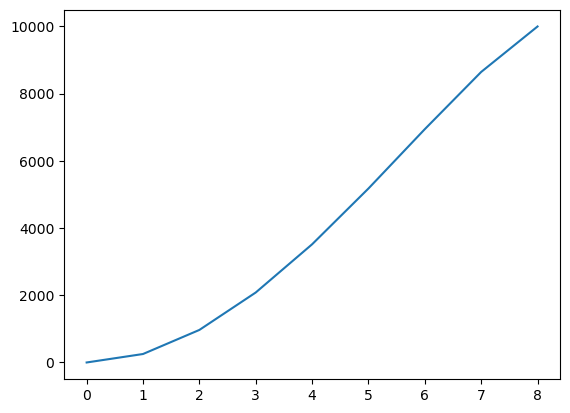

In [6]:
from collections import Counter
from scipy import stats

def entropy_of_sequence(input_list):
    # get counts
    count_data = list(Counter(input_list).values())
    
    # get entropy from counts
    entropy = stats.entropy(count_data)  
    
    return entropy

sequence = np.ones(shape=num_meals)
reward_list = []
max_entropy = entropy_of_sequence(list(range(num_meals)))
for num_unique in range(num_meals):
    sequence_to_test = list(range(num_unique)) + [-1] * (num_meals - num_unique)
    entropy_fraction = entropy_of_sequence(sequence_to_test) / max_entropy
    reward = (100 * entropy_fraction)**2
    reward_list.append(reward)
plt.plot(reward_list)